In [57]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import pycuber as pc
import random
from collections import defaultdict
import functools

from scipy.spatial import distance_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn.pool import global_mean_pool

from classes.cube_classes import Cube3State, Cube3
from generate.generate_states import ids_to_color
from utils.random_seed import seed_worker, seed_all, init_weights
from utils.compressions import *

torch.set_default_dtype(torch.float64)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_pickle('data/5_moves_dataset_single.pkl')

In [3]:
def indices_to_position(indices):
    pos_array = np.array([
        [0.5, 0.5, 0], [1.5, 0.5, 0], [2.5, 0.5, 0],
        [0.5, 1.5, 0], [1.5, 1.5, 0], [2.5, 1.5, 0],
        [0.5, 2.5, 0], [1.5, 2.5, 0], [2.5, 2.5, 0],
        
        [2.5, 0.5, 3], [1.5, 0.5, 3], [0.5, 0.5, 3],
        [2.5, 1.5, 3], [1.5, 1.5, 3], [0.5, 1.5, 3],
        [2.5, 2.5, 3], [1.5, 2.5, 3], [0.5, 2.5, 3],
        
        [2.5, 0, 2.5], [2.5, 0, 1.5], [2.5, 0, 0.5],
        [1.5, 0, 2.5], [1.5, 0, 1.5], [1.5, 0, 0.5],
        [0.5, 0, 2.5], [0.5, 0, 1.5], [0.5, 0, 0.5],
        
        [0.5, 3, 2.5], [0.5, 3, 1.5], [0.5, 3, 0.5],
        [1.5, 3, 2.5], [1.5, 3, 1.5], [1.5, 3, 0.5],
        [2.5, 3, 2.5], [2.5, 3, 1.5], [2.5, 3, 0.5],
        
        [3, 2.5, 2.5], [3, 2.5, 1.5], [3, 2.5, 0.5],
        [3, 1.5, 2.5], [3, 1.5, 1.5], [3, 1.5, 0.5],
        [3, 0.5, 2.5], [3, 0.5, 1.5], [3, 0.5, 0.5],
        
        [0, 0.5, 2.5], [0, 0.5, 1.5], [0, 0.5, 0.5],
        [0, 1.5, 2.5], [0, 1.5, 1.5], [0, 1.5, 0.5],
        [0, 2.5, 2.5], [0, 2.5, 1.5], [0, 2.5, 0.5],
    ])
    return pos_array[np.array(indices)]

## Network

In [45]:
class GCNNet(torch.nn.Module):
    def __init__(self, hidden_channels, node_features_size=10):
        super(GCNNet, self).__init__()
        self.conv1 = gnn.GCNConv(node_features_size, hidden_channels)
        self.conv2 = gnn.GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = self.conv2(x, edge_index, edge_attr)
        x = global_mean_pool(x, data.batch if data.batch is not None else torch.zeros((data.x.size(0)), dtype=torch.int64))
        x = self.lin(x)
        return x

In [46]:
nettt = GCNNet(10)
dlll = DataLoader(data_list_sparse_graph, batch_size=2)
nettt(next(iter(dlll)))
nettt(data_list_sparse_graph[0])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
None


tensor([[0.3047]], grad_fn=<AddmmBackward0>)

## 1. SparseGraphNet

In [5]:
@functools.lru_cache
def calc_distances(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    dist_mat = distance_matrix(vertices, vertices)  # pouze se stredem
    return dist_mat

In [6]:
def find_middle(vertices):
    for vertex in vertices:
        if (vertex[0] == vertex[1] == 1.5) or (vertex[0] == vertex[2] == 1.5) or (vertex[1] == vertex[2] == 1.5):
            return vertex
    return None

In [7]:
def create_sparse_graph_data_obj(colors, distance_from_goal, node_features_size, verbose=False, aggregate=False, for_hashing=False):
    indices = np.arange(54)
    colors = np.array(colors)
    node_features = np.ones((54, node_features_size))
    edge_index = []
    edge_attr = []
    curr_idx = 0
    for color in range(6):
        filtered_indices = indices[colors == color]
        position_filtered_indices = indices_to_position(filtered_indices)
        middle = find_middle(position_filtered_indices)
        distances = distance_matrix(position_filtered_indices, middle.reshape(1, -1))
        ctr = 0
        for i in range(len(filtered_indices)):
#             print(position_filtered_indices[i])
#             print(middle)
            if (position_filtered_indices[i] == middle).all():
                continue
            node_i = curr_idx + ctr + 1
            node_j = curr_idx
            edge_index.append([node_i, node_j])
            edge_attr.append(distances[i].item())
            edge_index.append([node_j, node_i])
            edge_attr.append(distances[i].item())
            ctr += 1
        curr_idx += len(filtered_indices)
    y = distance_from_goal
    data = Data(x=torch.Tensor(node_features), edge_index=torch.Tensor(edge_index).T.long() , edge_attr=torch.Tensor(edge_attr).unsqueeze(1), y=torch.Tensor([y]))
    return data

In [8]:
data_list_sparse_graph = []
for _, row in tqdm(df.iterrows()):
    data_list_sparse_graph.append(create_sparse_graph_data_obj(row['colors'], row['distance'], node_features_size=10))

105045it [04:51, 359.78it/s]


In [9]:
loader_sparseGraph = DataLoader(data_list_sparse_graph, batch_size=128)

In [10]:
netSparseGraph = GCNNet(10)

In [11]:
data_list_sparse_graph[0].edge_attr.size()

torch.Size([96, 1])

In [12]:
## Training loop
optimizer = torch.optim.Adam(netSparseGraph.parameters(), lr=0.001)

for epoch in range(10):
    netSparseGraph.train()
    total = 0
    total_loss = 0.0
    for i, data in tqdm(enumerate(loader_sparseGraph)):
        optimizer.zero_grad()
        out = netSparseGraph(data)
        loss = F.mse_loss(out.squeeze(), data.y.squeeze(), reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += data.y.size(0)
        optimizer.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

821it [00:41, 19.82it/s]
3it [00:00, 21.21it/s]

Epoch 1: train loss 1.4833


821it [00:41, 20.00it/s]
2it [00:00, 19.89it/s]

Epoch 2: train loss 0.0561


821it [00:40, 20.23it/s]
2it [00:00, 19.15it/s]

Epoch 3: train loss 0.0553


821it [00:40, 20.15it/s]
3it [00:00, 20.27it/s]

Epoch 4: train loss 0.0550


821it [00:39, 20.79it/s]
3it [00:00, 20.83it/s]

Epoch 5: train loss 0.0549


821it [00:39, 20.78it/s]
3it [00:00, 20.32it/s]

Epoch 6: train loss 0.0549


821it [00:39, 20.76it/s]
3it [00:00, 21.02it/s]

Epoch 7: train loss 0.0549


821it [00:40, 20.27it/s]
2it [00:00, 19.57it/s]

Epoch 8: train loss 0.0549


821it [00:41, 19.74it/s]
3it [00:00, 21.21it/s]

Epoch 9: train loss 0.0546


821it [00:40, 20.41it/s]

Epoch 10: train loss 0.0549


### Activation compressions

In [13]:
networksSparseGraph = create_networks(NetworkClass=GCNNet, network_args={'hidden_channels': 16}, num_of_networks=10)
distance_all_acts_sparse_graph = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=create_sparse_graph_data_obj, networks=networksSparseGraph, is_graph_nn=True)

100%|██████████████████████████████████████████████████████████████████████████| 93840/93840 [4:41:16<00:00,  5.56it/s]


In [14]:
distance_all_acts_sparse_graph[0]

defaultdict(list,
            {(13496093,
              44458860,
              22281447,
              -9268810,
              -59609559,
              24779107,
              81240235,
              -10549248,
              31052158,
              -12572823): [(0, [["U'"]]),
              (1, [["R'"]]),
              (2, [["D'"]]),
              (3, [["L'"]]),
              (4, [["F'"]]),
              (5, [["B'"]]),
              (6, [['U']]),
              (7, [['R']]),
              (8, [['D']]),
              (9, [['L']]),
              (10, [['F']]),
              (11, [['B']])]})

In [15]:
with open('data/temp/distance_all_acts_sparse_graph.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_sparse_graph, f)

In [ ]:
set_intersections_activations_sparse_graph = compute_set_intersections(distance_all_acts_sparse_graph)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 3
Intersection size between sets 4 AND 5: 0


In [ ]:
# INTERSECTION_BETWEEN = (2,3)
# common_activation = list(set_intersections_activations_sparse_graph[INTERSECTION_BETWEEN])[0]
# gen1 = distance_all_acts_sparse_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
# print(gen1)
# gen2 = distance_all_acts_sparse_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
# print(gen2)
w
# cube1 = pc.Cube()
# print(' '.join(gen1))
# cube1(' '.join(gen1))
# display(cube1)

# cube2 = pc.Cube()
# print(' '.join(gen2))
# cube2(' '.join(gen2))
# display(cube2)

In [62]:
with open('data/temp/distance6_all_acts_sparse_graph.pkl', 'rb') as f:
    distance6_all_acts_sparse_graph = pickle.load(f)

In [63]:
set_intersections_activations_sparse_graph_6 = compute_set_intersections(distance6_all_acts_sparse_graph)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 1 AND 6: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 2 AND 6: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 3
Intersection size between sets 3 AND 6: 1
Intersection size between sets 4 AND 5: 0
Intersection size between sets 4 AND 6: 22
Intersection size between sets 5 AND 6: 24


In [65]:
INTERSECTION_BETWEEN = (3,5)
intersection_list = list(set_intersections_activations_sparse_graph_6[INTERSECTION_BETWEEN])
for common_activation in intersection_list:
    gen1 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
    print(gen1)
    gen2 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
    print(gen2)

    cube1 = pc.Cube()
    print(' '.join(gen1))
    cube1(' '.join(gen1))
    display(cube1)

    cube2 = pc.Cube()
    print(' '.join(gen2))
    cube2(' '.join(gen2))
    display(cube2)
    print(3*'\n')

["U'", 'L', 'F']
["U'", "U'", "L'", 'U', 'B']
U' L F


U' U' L' U B






["U'", 'L', "F'"]
["U'", "U'", "L'", 'U', "B'"]
U' L F'


U' U' L' U B'






["U'", "L'", 'B']
["U'", "L'", 'B', "L'", "L'"]
U' L' B


U' L' B L' L'


In [66]:
INTERSECTION_BETWEEN = (3,6)
intersection_list = list(set_intersections_activations_sparse_graph_6[INTERSECTION_BETWEEN])
for common_activation in intersection_list:
    gen1 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
    print(gen1)
    gen2 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
    print(gen2)

    cube1 = pc.Cube()
    print(' '.join(gen1))
    cube1(' '.join(gen1))
    display(cube1)

    cube2 = pc.Cube()
    print(' '.join(gen2))
    cube2(' '.join(gen2))
    display(cube2)
    print(3*'\n')

["U'", 'L', 'U']
["U'", 'L', 'U', 'D', 'L', 'D']
U' L U


U' L U D L D


In [64]:
INTERSECTION_BETWEEN = (4,6)
intersection_list = list(set_intersections_activations_sparse_graph_6[INTERSECTION_BETWEEN])
for common_activation in intersection_list:
    gen1 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
    print(gen1)
    gen2 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
    print(gen2)

    cube1 = pc.Cube()
    print(' '.join(gen1))
    cube1(' '.join(gen1))
    display(cube1)

    cube2 = pc.Cube()
    print(' '.join(gen2))
    cube2(' '.join(gen2))
    display(cube2)
    print(3*'\n')

["U'", "L'", 'D', 'F']
["U'", "U'", "D'", "L'", 'U', 'B']
U' L' D F


U' U' D' L' U B






["U'", 'L', 'F', "B'"]
["U'", 'L', 'F', "L'", "B'", 'L']
U' L F B'


U' L F L' B' L






["U'", "L'", 'U', 'F']
["U'", "U'", "L'", "F'", 'L', 'U']
U' L' U F


U' U' L' F' L U






["U'", "L'", 'B', "R'"]
["U'", "D'", "L'", "U'", 'F', 'U']
U' L' B R'


U' D' L' U' F U






["U'", "L'", 'B', 'R']
["U'", "L'", 'B', "L'", "L'", 'R']
U' L' B R


U' L' B L' L' R






["U'", 'L', 'F', "L'"]
["U'", "L'", 'U', "B'", "L'", "U'"]
U' L F L'


U' L' U B' L' U'






["U'", "L'", "D'", "L'"]
["U'", 'L', 'U', 'L', 'D', 'F']
U' L' D' L'


U' L U L D F






["U'", "D'", "L'", 'R']
["U'", 'L', "D'", 'L', "U'", 'B']
U' D' L' R


U' L D' L U' B






["U'", "U'", "L'", "R'"]
["U'", "U'", "L'", "L'", "U'", "D'"]
U' U' L' R'


U' U' L' L' U' D'






["U'", 'D', "L'", 'B']
["U'", 'L', 'U', "R'", "U'", 'B']
U' D L' B


U' L U R' U' B






["U'", 'L', "D'", "B'"]
["U'", "U'", "D'", 'L', "U'", "F'"]
U' L D' B'


U' U' D' L U' F'






["U'", 'L', "F'", "R'"]
["U'", "L'", 'U', "B'", 'U', "D'"]
U' L F' R'


U' L' U B' U D'






["U'", "U'", "L'", "L'"]
["U'", "D'", "L'", "L'", "U'", 'D']
U' U' L' L'


U' D' L' L' U' D






["U'", "L'", 'R', 'B']
["U'", "U'", "L'", 'U', "D'", 'B']
U' L' R B


U' U' L' U D' B






["U'", "L'", 'D', 'L']
["U'", "L'", 'D', 'L', "U'", "U'"]
U' L' D L


U' L' D L U' U'






["U'", "L'", 'U', "R'"]
["U'", "U'", "L'", "D'", 'L', 'U']
U' L' U R'


U' U' L' D' L U






["U'", "L'", 'F', 'L']
["U'", "L'", 'F', 'L', "U'", "U'"]
U' L' F L


U' L' F L U' U'






["U'", 'L', 'R', "U'"]
["U'", "L'", 'U', 'R', 'D', "L'"]
U' L R U'


U' L' U R D L'






["U'", "L'", 'R', "B'"]
["U'", "U'", "L'", 'U', "D'", "B'"]
U' L' R B'


U' U' L' U D' B'






["U'", 'L', "D'", 'B']
["U'", "U'", "D'", 'L', "U'", 'F']
U' L D' B


U' U' D' L U' F






["U'", "L'", 'R', "F'"]
["U'", "L'", 'U', 'R', "U'", "F'"]
U' L' R F'


U' L' U R U' F'






["U'", "L'", 'D', "F'"]
["U'", "U'", "D'", "L'", 'U', "B'"]
U' L' D F'


U' U' D' L' U B'


In [67]:
INTERSECTION_BETWEEN = (5,6)
intersection_list = list(set_intersections_activations_sparse_graph_6[INTERSECTION_BETWEEN])
for common_activation in intersection_list:
    gen1 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
    print(gen1)
    gen2 = distance6_all_acts_sparse_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
    print(gen2)

    cube1 = pc.Cube()
    print(' '.join(gen1))
    cube1(' '.join(gen1))
    display(cube1)

    cube2 = pc.Cube()
    print(' '.join(gen2))
    cube2(' '.join(gen2))
    display(cube2)
    print(3*'\n')

["U'", 'L', "B'", 'R', 'F']
["U'", "L'", "F'", "B'", 'D', 'L']
U' L B' R F


U' L' F' B' D L






["U'", 'L', 'F', "R'", "R'"]
["U'", 'L', 'F', "R'", "B'", 'R']
U' L F R' R'


U' L F R' B' R






["U'", "U'", "L'", "D'", 'B']
["U'", 'L', "D'", "L'", "F'", "D'"]
U' U' L' D' B


U' L D' L' F' D'






["U'", "L'", "F'", 'U', 'R']
["U'", "L'", "U'", 'F', 'L', "D'"]
U' L' F' U R


U' L' U' F L D'






["U'", "L'", 'F', "B'", "D'"]
["U'", "D'", "L'", "F'", "R'", 'D']
U' L' F B' D'


U' D' L' F' R' D






["U'", "U'", "L'", "R'", 'D']
["U'", "L'", 'F', "D'", "B'", "D'"]
U' U' L' R' D


U' L' F D' B' D'






["U'", 'L', "U'", "L'", 'D']
["U'", "L'", "U'", "D'", 'L', "D'"]
U' L U' L' D


U' L' U' D' L D'






["U'", 'L', 'F', "L'", 'D']
["U'", "L'", 'R', "B'", "R'", 'F']
U' L F L' D


U' L' R B' R' F






["U'", 'L', "U'", "F'", "R'"]
["U'", "L'", 'U', "R'", "R'", 'B']
U' L U' F' R'


U' L' U R' R' B






["U'", 'L', 'R', 'D', "F'"]
["U'", 'L', "U'", 'R', "U'", 'B']
U' L R D F'


U' L U' R U' B






["U'", 'L', 'R', 'D', "L'"]
["U'", "D'", "L'", 'F', 'L', 'R']
U' L R D L'


U' D' L' F L R






["U'", "L'", "B'", "B'", 'U']
["U'", 'L', "U'", "B'", "L'", 'U']
U' L' B' B' U


U' L U' B' L' U






["U'", "L'", 'R', 'B', "R'"]
["U'", "U'", "L'", 'U', 'B', 'D']
U' L' R B R'


U' U' L' U B D






["U'", 'L', "U'", "L'", "D'"]
["U'", 'L', 'U', 'F', 'B', "D'"]
U' L U' L' D'


U' L U F B D'






["U'", "L'", 'B', 'D', "R'"]
["U'", 'L', "B'", "R'", 'D', "F'"]
U' L' B D R'


U' L B' R' D F'






["U'", 'L', "U'", "D'", "D'"]
["U'", "L'", 'B', "R'", 'F', "L'"]
U' L U' D' D'


U' L' B R' F L'






["U'", "L'", "B'", 'D', "B'"]
["U'", 'L', "U'", "R'", "D'", 'F']
U' L' B' D B'


U' L U' R' D' F






["U'", 'D', "L'", 'U', 'R']
["U'", "U'", "L'", 'U', 'L', "D'"]
U' D L' U R


U' U' L' U L D'






["U'", 'L', "F'", "D'", "D'"]
["U'", "L'", "U'", 'L', 'F', 'L']
U' L F' D' D'


U' L' U' L F L






["U'", "U'", "D'", 'L', 'F']
["U'", "L'", 'R', 'F', "U'", 'L']
U' U' D' L F


U' L' R F U' L






["U'", 'D', "L'", "B'", "D'"]
["U'", "L'", 'D', 'B', 'U', 'B']
U' D L' B' D'


U' L' D B U B






["U'", "L'", 'D', 'L', 'B']
["U'", 'L', "F'", "F'", 'R', 'U']
U' L' D L B


U' L F' F' R U






["U'", "L'", "D'", 'R', 'U']
["U'", 'D', "L'", "U'", "U'", "L'"]
U' L' D' R U


U' D L' U' U' L'






["U'", "L'", "F'", 'U', "R'"]
["U'", 'L', 'U', "F'", "B'", "R'"]
U' L' F' U R'


U' L U F' B' R'


In [ ]:
# common_activation

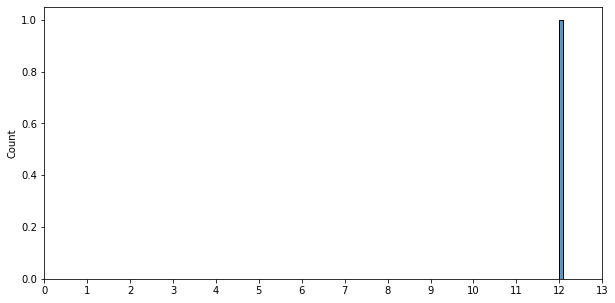

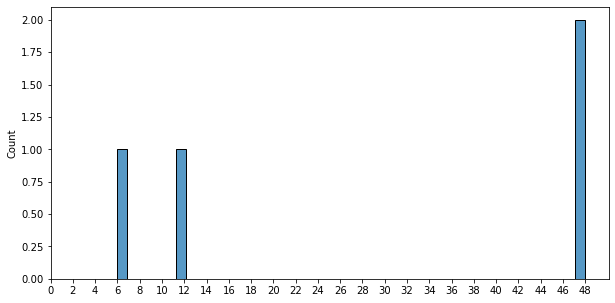

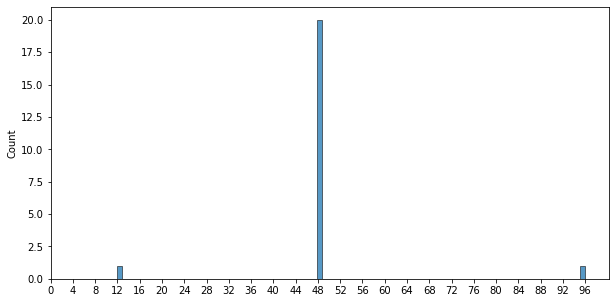

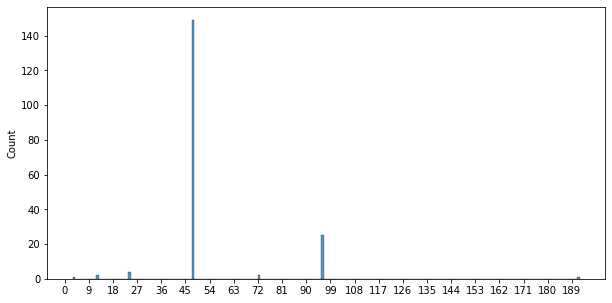

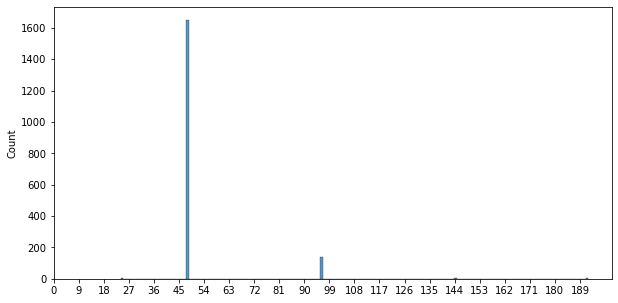

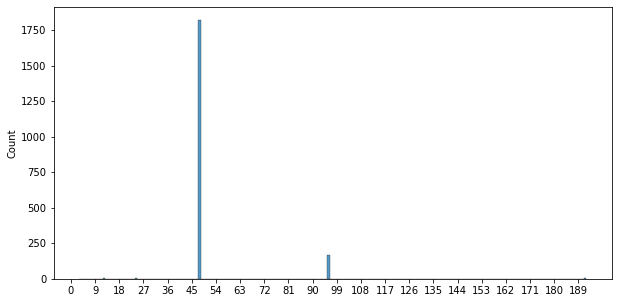

In [ ]:
plot_distance_compressions(distance_all_acts_sparse_graph, 'sparseGraphNet/from_activations')

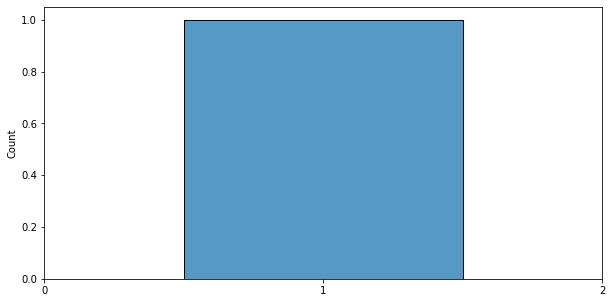

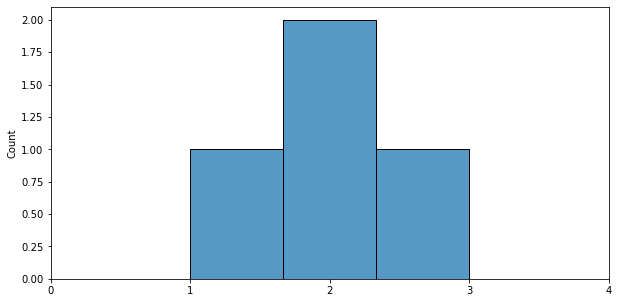

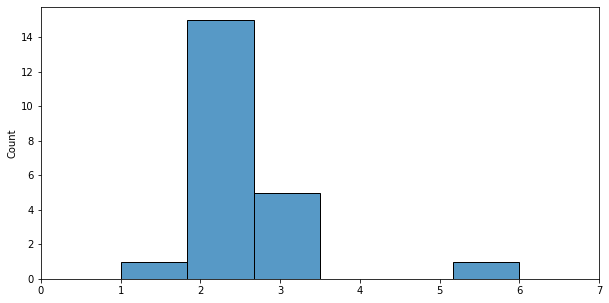

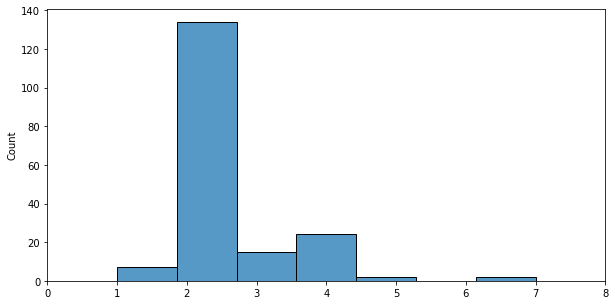

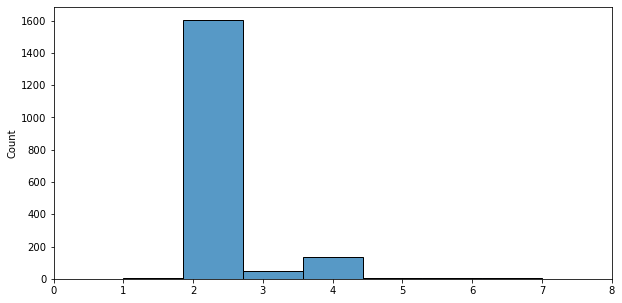

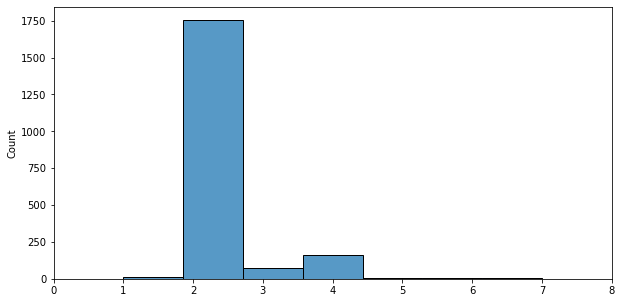

In [ ]:
plot_class_ids_per_compressions(distance_all_acts_sparse_graph, df, 'sparseGraphNet/from_activations')

## 2. CompleteGraphsNet

In [ ]:
@functools.lru_cache
def calc_distances(filtered_indices):
    vertices = indices_to_position(filtered_indices)
    dist_mat = distance_matrix(vertices, vertices)  # pouze se stredem
    return dist_mat

In [ ]:
def create_complete_graph_data_obj(colors, distance_from_goal, node_features_size, verbose=False, aggregate=False, for_hashing=False):
    indices = np.arange(54)
    colors = np.array(colors)
    node_features = np.ones((54, node_features_size))
    edge_index = []
    edge_attr = []
    curr_idx = 0
    for color in range(6):
        filtered_indices = indices[colors == color]
        dist_mat = calc_distances(tuple(filtered_indices))
        for i in range(len(filtered_indices)):
            for j in range(len(filtered_indices)):
                node_i = curr_idx + i
                node_j = curr_idx + j
                edge_index.append([node_i, node_j])
                edge_attr.append(dist_mat[i,j])
        curr_idx += len(filtered_indices)
    y = distance_from_goal
    data = Data(x=torch.Tensor(node_features), edge_index=torch.Tensor(edge_index).T.long() , edge_attr=torch.Tensor(edge_attr).unsqueeze(1), y=torch.Tensor([y]))
    return data

In [ ]:
data_list_complete_graph = []
for _, row in tqdm(df.iterrows()):
    data_list_complete_graph.append(create_complete_graph_data_obj(row['colors'], row['distance'], node_features_size=10))

105045it [05:19, 328.44it/s]


In [ ]:
loader_compGraph = DataLoader(data_list_complete_graph, batch_size=128)

In [ ]:
netCompGraph = GCNNet(10)

In [ ]:
## Training loop
optimizer = torch.optim.Adam(netCompGraph.parameters(), lr=0.001)

for epoch in range(10):
    netCompGraph.train()
    total = 0
    total_loss = 0.0
    for i, data in tqdm(enumerate(loader_compGraph)):
        optimizer.zero_grad()
        out = netCompGraph(data)
        loss = F.mse_loss(out.squeeze(), data.y.squeeze(), reduction='sum')
        loss.backward()
        total_loss += loss.item()
        total += data.y.size(0)
        optimizer.step()
    if (epoch+1) % 1 == 0:
        print(f'Epoch {epoch+1}: train loss {total_loss/total:0.4f}')

821it [01:17, 10.60it/s]
2it [00:00, 11.53it/s]

Epoch 1: train loss 0.9887


821it [01:16, 10.77it/s]
1it [00:00,  8.59it/s]

Epoch 2: train loss 0.0547


821it [01:17, 10.53it/s]
2it [00:00, 10.86it/s]

Epoch 3: train loss 0.0554


821it [01:17, 10.60it/s]
1it [00:00,  9.95it/s]

Epoch 4: train loss 0.0560


821it [01:17, 10.55it/s]
0it [00:00, ?it/s]

Epoch 5: train loss 0.0562


821it [01:18, 10.50it/s]
0it [00:00, ?it/s]

Epoch 6: train loss 0.0562


821it [01:20, 10.19it/s]
1it [00:00,  9.97it/s]

Epoch 7: train loss 0.0561


821it [01:17, 10.65it/s]
0it [00:00, ?it/s]

Epoch 8: train loss 0.0559


821it [01:17, 10.57it/s]
2it [00:00, 10.76it/s]

Epoch 9: train loss 0.0558


821it [01:17, 10.57it/s]

Epoch 10: train loss 0.0556


### Activation compressions

In [ ]:
networksCompGraph = create_networks(NetworkClass=GCNNet, network_args={'hidden_channels': 16}, num_of_networks=10)
distance_all_acts_complete_graph = calculate_all_dicts_from_activations(df=df, max_distance=5, input_handling_func=create_complete_graph_data_obj, networks=networksCompGraph, is_graph_nn=True)

100%|██████████████████████████████████████████████████████████████████████████| 93840/93840 [1:34:17<00:00, 16.59it/s]


In [ ]:
distance_all_acts_complete_graph[0]

defaultdict(list,
            {(12702411,
              47539742,
              23147160,
              -8020863,
              -63807530,
              26798242,
              86597627,
              -10218087,
              32234794,
              -11582975): [(0, [["U'"]]),
              (1, [["R'"]]),
              (2, [["D'"]]),
              (3, [["L'"]]),
              (4, [["F'"]]),
              (5, [["B'"]]),
              (6, [['U']]),
              (7, [['R']]),
              (8, [['D']]),
              (9, [['L']]),
              (10, [['F']]),
              (11, [['B']])]})

In [ ]:
with open('data/temp/distance_all_acts_complete_graph.pkl', 'wb') as f:
    pickle.dump(distance_all_acts_complete_graph, f)

In [ ]:
set_intersections_activations_complete_graph = compute_set_intersections(distance_all_acts_complete_graph)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 4 AND 5: 0


In [ ]:
# INTERSECTION_BETWEEN = (2,3)
# common_activation = list(set_intersections_activations_complete_graph[INTERSECTION_BETWEEN])[0]
# gen1 = distance_all_acts_complete_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
# print(gen1)
# gen2 = distance_all_acts_complete_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
# print(gen2)

# cube1 = pc.Cube()
# print(' '.join(gen1))
# cube1(' '.join(gen1))
# display(cube1)

# cube2 = pc.Cube()
# print(' '.join(gen2))
# cube2(' '.join(gen2))
# display(cube2)

In [59]:
with open('data/temp/distance6_all_acts_complete_graph.pkl', 'rb') as f:
    distance6_all_acts_complete_graph = pickle.load(f)

In [60]:
set_intersections_activations_complete_graph_6 = compute_set_intersections(distance6_all_acts_complete_graph)

Intersection size between sets 1 AND 2: 0
Intersection size between sets 1 AND 3: 0
Intersection size between sets 1 AND 4: 0
Intersection size between sets 1 AND 5: 0
Intersection size between sets 1 AND 6: 0
Intersection size between sets 2 AND 3: 0
Intersection size between sets 2 AND 4: 0
Intersection size between sets 2 AND 5: 0
Intersection size between sets 2 AND 6: 1
Intersection size between sets 3 AND 4: 0
Intersection size between sets 3 AND 5: 0
Intersection size between sets 3 AND 6: 0
Intersection size between sets 4 AND 5: 0
Intersection size between sets 4 AND 6: 7
Intersection size between sets 5 AND 6: 55


In [68]:
INTERSECTION_BETWEEN = (2,6)
intersection_list = list(set_intersections_activations_complete_graph_6[INTERSECTION_BETWEEN])
for common_activation in intersection_list:
    gen1 = distance6_all_acts_complete_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
    print(gen1)
    gen2 = distance6_all_acts_complete_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
    print(gen2)

    cube1 = pc.Cube()
    print(' '.join(gen1))
    cube1(' '.join(gen1))
    display(cube1)

    cube2 = pc.Cube()
    print(' '.join(gen2))
    cube2(' '.join(gen2))
    display(cube2)
    print(3*'\n')

["U'", "D'"]
["U'", 'D', "L'", "U'", 'F', "D'"]
U' D'


U' D L' U' F D'


In [61]:
INTERSECTION_BETWEEN = (4,6)
intersection_list = list(set_intersections_activations_complete_graph_6[INTERSECTION_BETWEEN])
for common_activation in intersection_list:
    gen1 = distance6_all_acts_complete_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
    print(gen1)
    gen2 = distance6_all_acts_complete_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
    print(gen2)

    cube1 = pc.Cube()
    print(' '.join(gen1))
    cube1(' '.join(gen1))
    display(cube1)

    cube2 = pc.Cube()
    print(' '.join(gen2))
    cube2(' '.join(gen2))
    display(cube2)
    print(3*'\n')

["U'", 'L', "U'", "R'"]
["U'", "L'", "F'", 'R', "D'", "R'"]
U' L U' R'


U' L' F' R D' R'






["U'", "L'", 'R', 'U']
["U'", "L'", "R'", 'F', "L'", "L'"]
U' L' R U


U' L' R' F L' L'






["U'", "D'", 'L', 'R']
["U'", 'L', 'D', 'R', "B'", "D'"]
U' D' L R


U' L D R B' D'






["U'", "L'", "D'", "R'"]
["U'", "L'", 'R', 'D', 'F', "R'"]
U' L' D' R'


U' L' R D F R'






["U'", "L'", 'B', 'D']
["U'", "L'", "D'", 'R', 'F', "D'"]
U' L' B D


U' L' D' R F D'






["U'", "L'", "R'", "D'"]
["U'", "L'", 'B', 'D', 'L', 'B']
U' L' R' D'


U' L' B D L B






["U'", "L'", "D'", "F'"]
["U'", 'L', 'U', 'F', "L'", "B'"]
U' L' D' F'


U' L U F L' B'


In [69]:
INTERSECTION_BETWEEN = (5,6)
intersection_list = list(set_intersections_activations_complete_graph_6[INTERSECTION_BETWEEN])
for common_activation in intersection_list:
    gen1 = distance6_all_acts_complete_graph[INTERSECTION_BETWEEN[0] - 1][common_activation][0][1][0]
    print(gen1)
    gen2 = distance6_all_acts_complete_graph[INTERSECTION_BETWEEN[1] - 1][common_activation][0][1][0]
    print(gen2)

    cube1 = pc.Cube()
    print(' '.join(gen1))
    cube1(' '.join(gen1))
    display(cube1)

    cube2 = pc.Cube()
    print(' '.join(gen2))
    cube2(' '.join(gen2))
    display(cube2)
    print(3*'\n')

["U'", "U'", "L'", "B'", 'R']
["U'", "L'", "B'", "R'", 'B', "U'"]
U' U' L' B' R


U' L' B' R' B U'






["U'", "L'", 'R', 'F', 'L']
["U'", 'L', 'U', "F'", 'R', 'U']
U' L' R F L


U' L U F' R U






["U'", "D'", "L'", 'R', 'U']
["U'", "D'", 'L', "U'", 'F', 'B']
U' D' L' R U


U' D' L U' F B






["U'", 'L', "U'", "D'", 'L']
["U'", 'L', 'D', "L'", 'R', "U'"]
U' L U' D' L


U' L D L' R U'






["U'", 'L', "U'", "D'", 'R']
["U'", "L'", 'F', 'B', 'D', 'F']
U' L U' D' R


U' L' F B D F






["U'", "D'", 'L', "U'", 'R']
["U'", 'L', "B'", 'R', "F'", "U'"]
U' D' L U' R


U' L B' R F' U'






["U'", "L'", 'R', "B'", 'R']
["U'", 'L', 'U', 'R', "D'", "L'"]
U' L' R B' R


U' L U R D' L'






["U'", 'L', "B'", "D'", "F'"]
["U'", "L'", 'D', 'F', "B'", "R'"]
U' L B' D' F'


U' L' D F B' R'






["U'", 'L', "U'", "D'", "L'"]
["U'", 'L', 'R', "F'", 'B', 'D']
U' L U' D' L'


U' L R F' B D






["U'", "L'", 'F', 'U', 'B']
["U'", "L'", "F'", 'R', 'U', 'L']
U' L' F U B


U' L' F' R U L






["U'", 'L', 'B', "D'", "R'"]
["U'", "L'", 'B', "L'", 'R', "F'"]
U' L B D' R'


U' L' B L' R F'






["U'", "L'", "L'", "D'", 'R']
["U'", "L'", "U'", "U'", 'F', "D'"]
U' L' L' D' R


U' L' U' U' F D'






["U'", "U'", "L'", "B'", 'L']
["U'", "L'", "L'", 'F', 'L', "F'"]
U' U' L' B' L


U' L' L' F L F'






["U'", 'L', "B'", "U'", 'L']
["U'", 'L', 'U', "B'", 'L', "F'"]
U' L B' U' L


U' L U B' L F'






["U'", 'L', 'R', 'F', "U'"]
["U'", 'L', 'U', 'L', "F'", 'U']
U' L R F U'


U' L U L F' U






["U'", "L'", "R'", "D'", "F'"]
["U'", "L'", 'F', "R'", 'D', 'R']
U' L' R' D' F'


U' L' F R' D R






["U'", 'L', 'B', "R'", "R'"]
["U'", "L'", 'F', "B'", 'R', "D'"]
U' L B R' R'


U' L' F B' R D'






["U'", "L'", "U'", 'D', 'L']
["U'", 'L', "F'", 'B', 'R', "B'"]
U' L' U' D L


U' L F' B R B'






["U'", 'L', 'U', "D'", 'F']
["U'", 'L', 'D', 'L', "D'", "R'"]
U' L U D' F


U' L D L D' R'






["U'", 'L', "F'", "D'", "F'"]
["U'", "L'", "D'", "D'", "L'", 'F']
U' L F' D' F'


U' L' D' D' L' F






["U'", 'L', "F'", 'L', 'U']
["U'", "L'", "B'", 'U', 'F', 'R']
U' L F' L U


U' L' B' U F R






["U'", "U'", "L'", "D'", "F'"]
["U'", "L'", "L'", "U'", "D'", "D'"]
U' U' L' D' F'


U' L' L' U' D' D'






["U'", "L'", 'F', "U'", "D'"]
["U'", "L'", "B'", 'U', "D'", 'L']
U' L' F U' D'


U' L' B' U D' L






["U'", "L'", 'B', "L'", "R'"]
["U'", 'L', 'F', 'L', "B'", "U'"]
U' L' B L' R'


U' L F L B' U'






["U'", "L'", "D'", 'F', 'L']
["U'", "L'", "L'", "B'", "L'", "B'"]
U' L' D' F L


U' L' L' B' L' B'






["U'", 'L', "U'", "F'", 'U']
["U'", "D'", "L'", 'R', 'F', "R'"]
U' L U' F' U


U' D' L' R F R'






["U'", 'L', 'R', 'F', 'D']
["U'", "L'", "U'", "B'", "D'", "B'"]
U' L R F D


U' L' U' B' D' B'






["U'", "L'", "L'", "B'", "R'"]
["U'", 'D', "L'", "R'", "F'", "R'"]
U' L' L' B' R'


U' D L' R' F' R'






["U'", "L'", 'R', 'F', 'U']
["U'", "L'", "U'", 'L', "D'", "L'"]
U' L' R F U


U' L' U' L D' L'






["U'", 'L', 'B', 'R', 'F']
["U'", "U'", "L'", "D'", 'F', 'D']
U' L B R F


U' U' L' D' F D






["U'", 'D', "L'", 'B', "D'"]
["U'", "L'", 'U', 'R', 'U', 'F']
U' D L' B D'


U' L' U R U F






["U'", "L'", "U'", "B'", "U'"]
["U'", 'L', 'U', "F'", "R'", "D'"]
U' L' U' B' U'


U' L U F' R' D'






["U'", 'L', "B'", "U'", "D'"]
["U'", "D'", "L'", 'R', "F'", 'B']
U' L B' U' D'


U' D' L' R F' B






["U'", 'L', "F'", "B'", 'R']
["U'", 'L', 'D', "L'", 'D', 'B']
U' L F' B' R


U' L D L' D B






["U'", "D'", 'L', "F'", "U'"]
["U'", 'L', 'R', 'D', 'F', 'D']
U' D' L F' U'


U' L R D F D






["U'", "L'", 'D', "R'", 'U']
["U'", 'L', 'B', 'D', "R'", 'F']
U' L' D R' U


U' L B D R' F






["U'", 'L', 'D', 'R', "D'"]
["U'", "L'", 'D', 'F', 'R', "D'"]
U' L D R D'


U' L' D F R D'






["U'", "L'", "F'", 'U', "R'"]
["U'", 'L', 'D', "B'", "D'", 'B']
U' L' F' U R'


U' L D B' D' B






["U'", "D'", 'L', "F'", 'L']
["U'", "U'", "L'", "F'", 'L', 'R']
U' D' L F' L


U' U' L' F' L R






["U'", 'L', "D'", 'L', "D'"]
["U'", 'L', "U'", "D'", "F'", 'D']
U' L D' L D'


U' L U' D' F' D






["U'", "L'", 'B', "D'", "B'"]
["U'", "L'", 'D', "F'", "D'", 'L']
U' L' B D' B'


U' L' D F' D' L






["U'", 'L', 'D', "R'", "B'"]
["U'", 'L', "B'", "L'", "L'", 'F']
U' L D R' B'


U' L B' L' L' F






["U'", 'L', "D'", 'L', "F'"]
["U'", "L'", "U'", "U'", "F'", 'R']
U' L D' L F'


U' L' U' U' F' R






["U'", "L'", "F'", 'U', 'D']
["U'", "U'", "L'", 'D', "B'", "D'"]
U' L' F' U D


U' U' L' D B' D'






["U'", 'L', 'F', "U'", "R'"]
["U'", 'L', "F'", "U'", 'D', "B'"]
U' L F U' R'


U' L F' U' D B'






["U'", "L'", "L'", "F'", 'B']
["U'", 'L', "F'", 'B', "L'", "R'"]
U' L' L' F' B


U' L F' B L' R'






["U'", "L'", 'F', "R'", "D'"]
["U'", "L'", "U'", 'D', "B'", "R'"]
U' L' F R' D'


U' L' U' D B' R'






["U'", 'L', 'B', "L'", 'F']
["U'", "U'", "L'", "D'", 'R', "B'"]
U' L B L' F


U' U' L' D' R B'






["U'", "L'", "B'", "U'", "D'"]
["U'", "L'", 'R', "D'", "B'", 'D']
U' L' B' U' D'


U' L' R D' B' D






["U'", 'L', "B'", "R'", "B'"]
["U'", 'L', 'B', "D'", "L'", 'B']
U' L B' R' B'


U' L B D' L' B






["U'", 'D', "L'", 'B', "R'"]
["U'", "L'", "U'", 'F', "D'", 'R']
U' D L' B R'


U' L' U' F D' R






["U'", "L'", 'D', 'R', 'F']
["U'", 'L', "F'", 'R', 'F', 'R']
U' L' D R F


U' L F' R F R






["U'", "L'", "D'", "D'", "L'"]
["U'", 'L', "F'", 'R', 'B', 'D']
U' L' D' D' L'


U' L F' R B D






["U'", 'L', "U'", "B'", 'D']
["U'", "L'", "L'", "D'", 'F', 'U']
U' L U' B' D


U' L' L' D' F U






["U'", 'L', "B'", "D'", 'F']
["U'", "L'", 'F', 'B', "L'", "F'"]
U' L B' D' F


U' L' F B L' F'


In [ ]:
# common_activation

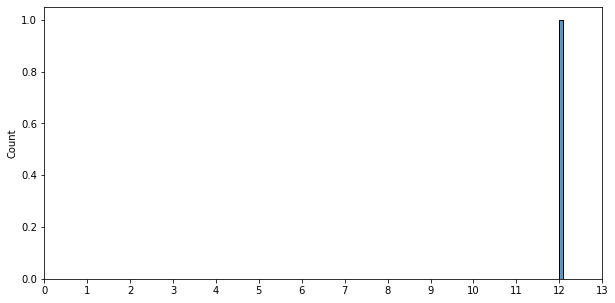

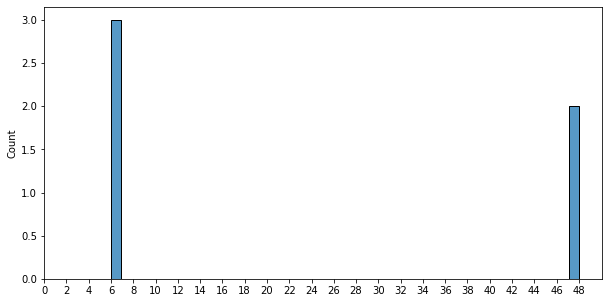

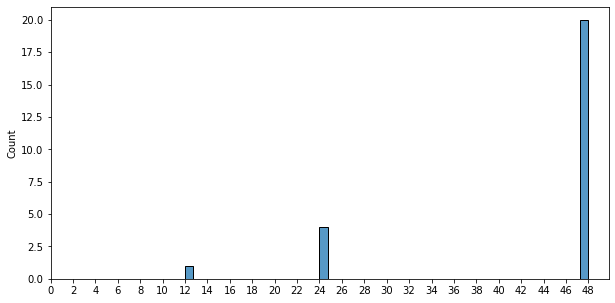

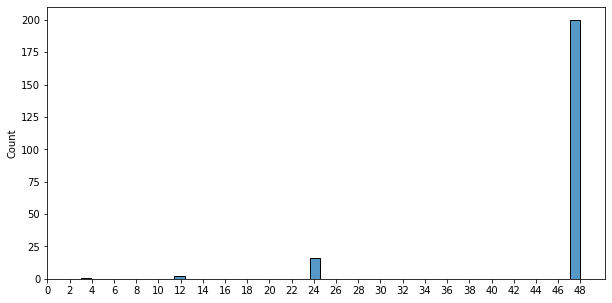

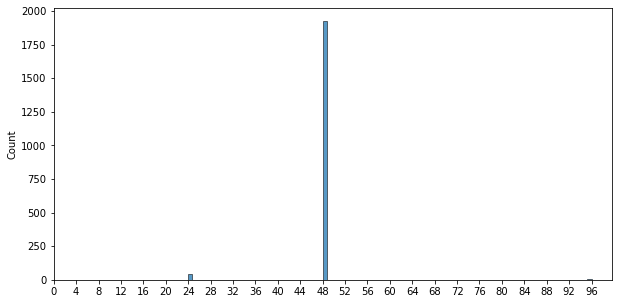

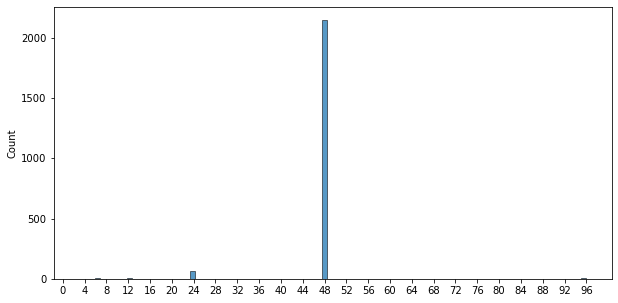

In [ ]:
plot_distance_compressions(distance_all_acts_complete_graph, 'completeGraphNet/from_activations')

In [49]:
plot_class_ids_per_compressions(distance_all_acts_complete_graph, df, 'completeGraphNet/from_activations')

ValueError: ('Lengths must match to compare', (105045,), (1, 1))